# Preprocesamiento de Datos para un Modelo de Clasificación

Nuestro equipo de riesgo ha identificado la necesidad de construir un modelo de clasificación para detectar transacciones potencialmente fraudulentas o anómalas. El éxito de este modelo permitirá identificar patrones en los datos y reducir pérdidas económicas para nuestros clientes y la empresa. Tu trabajo para hoy será preparar los datos proporcionados para desarrollar un modelo de clasificación que prediga la probabilidad de que una transacción sea “Normal” o “Anómala”, basándose en las características de las transacciones. Dentro de las tareas que tienes que realizar hoy deben estar incluidas las siguientes: 


1. **Análisis exploratorio de datos (EDA):**

   - Visualizar la distribución de las principales variables.

   - Explorar relaciones entre las características y la variable objetivo (`IsFraudulent`).


2. **Limpieza de datos:**

   - Identificar y tratar valores nulos.

   - Eliminar duplicados si existen.

   - Asegurar que las variables tienen el tipo de dato correcto.

   - etc. 

3. **Transformación de variables:**

   - Normalizar o escalar variables numéricas según sea necesario.

   - Codificar variables categóricas con técnicas como One-Hot Encoding, Target Encoding u Ordinal Encoding, según corresponda.

   - Crear variables derivadas útiles, como:

     - Frecuencia de transacciones de cada cliente.

     - Diferencia de tiempo entre transacciones consecutivas.

     - Ratio entre el saldo posterior y el monto de la transacción.

## Datos Proporcionados

El archivo de datos que analizarán contiene transacciones reales registradas por una compañia. A continuación, se describen las principales columnas que deberán preprocesar:

| Columna               | Descripción                                                                                     |
|-----------------------|-------------------------------------------------------------------------------------------------|
| `transaction_id`      | Identificador único de la transacción.                                                         |
| `customer_id`         | Identificador único del cliente que realizó la transacción.                                    |
| `merchant_id`         | Identificador único del comercio donde se realizó la transacción.                              |
| `amount`              | Monto de la transacción (en la moneda correspondiente).                                        |
| `transaction_time`    | Fecha y hora exacta en la que ocurrió la transacción.                                          |
| `is_fraudulent`       | Indicador de si la transacción fue fraudulenta (1: Sí, 0: No).                                 |
| `card_type`           | Tipo de tarjeta utilizada para la transacción (Visa, MasterCard, American Express, Discover).  |
| `location`            | Ubicación (ciudad o región) donde se realizó la transacción.                                   |
| `purchase_category`   | Categoría de la compra (por ejemplo, Gas Station, Online Shopping, Retail, etc.).              |
| `customer_age`        | Edad del cliente en el momento de la transacción.                                              |
| `transaction_description` | Descripción breve de la transacción, usualmente incluye el comercio asociado.              |


In [1]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd
from itertools import product
from itertools import combinations
from scipy.stats import chi2_contingency
# Otros objetivos
# -----------------------------------------------------------------------
import math

import sys

sys.path.append('../') #pongo los 2 puntos para que salga de la carpeta
import src.funciones as f

# Gráficos
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt


# Para tratar el problema de desbalance
# -----------------------------------------------------------------------
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

# Outliers
from scipy.stats import zscore # para calcular el z-score
from sklearn.neighbors import LocalOutlierFactor # para detectar outliers usando el método LOF
from sklearn.ensemble import IsolationForest # para detectar outliers usando el metodo IF
from sklearn.neighbors import NearestNeighbors 

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('datos\\financial_data.csv')
# llamar a DF 

In [3]:
df.head()
# conocer sus datos

,transaction_id,customer_id,merchant_id,amount,transaction_time,is_fraudulent,card_type,location,purchase_category,customer_age,transaction_description
0,1,1082,2027,5758.59,2023-01-01 00:00:00,0,MasterCard,City-30,Gas Station,43,Purchase at Merchant-2027
1,2,1015,2053,1901.56,2023-01-01 00:00:01,1,Visa,City-47,Online Shopping,61,Purchase at Merchant-2053
2,3,1004,2035,1248.86,2023-01-01 00:00:02,1,MasterCard,City-6,Gas Station,57,Purchase at Merchant-2035
3,4,1095,2037,7619.05,2023-01-01 00:00:03,1,Discover,City-6,Travel,59,Purchase at Merchant-2037
4,5,1036,2083,1890.10,2023-01-01 00:00:04,1,MasterCard,City-34,Retail,36,Purchase at Merchant-2083


In [4]:
df.info()
# comprobar tipos y nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   transaction_id           10000 non-null  int64  
 1   customer_id              10000 non-null  int64  
 2   merchant_id              10000 non-null  int64  
 3   amount                   10000 non-null  float64
 4   transaction_time         10000 non-null  object 
 5   is_fraudulent            10000 non-null  int64  
 6   card_type                10000 non-null  object 
 7   location                 10000 non-null  object 
 8   purchase_category        10000 non-null  object 
 9   customer_age             10000 non-null  int64  
 10  transaction_description  10000 non-null  object 
dtypes: float64(1), int64(5), object(5)
memory usage: 859.5+ KB


In [5]:
df.nunique()
# ver las categrías distintas para cada columna

transaction_id             10000
customer_id                  100
merchant_id                  100
amount                      9945
transaction_time           10000
is_fraudulent                  2
card_type                      4
location                      50
purchase_category              6
customer_age                  53
transaction_description      100
dtype: int64

In [6]:
f.exploracion_dataframe(df, 'is_fraudulent')
# conocer mis columnas

El número de datos es 10000 y el de columnas es 11

 ..................... 

Los duplicados que tenemos en el conjunto de datos son: 0

 ..................... 

Los nulos que tenemos en el conjunto de datos son:


,%_nulos



 ..................... 

Los tipos de las columnas son:


,tipo_dato
transaction_id,int64
customer_id,int64
merchant_id,int64
amount,float64
transaction_time,object
is_fraudulent,int64
card_type,object
location,object
purchase_category,object
customer_age,int64



 ..................... 

Los valores que tenemos para las columnas categóricas son: 
La columna transaction_time tiene las siguientes valore únicos:


,count
transaction_time,
2023-01-01 00:00:00,1
2023-01-01 01:51:10,1
2023-01-01 01:51:03,1
2023-01-01 01:51:04,1
2023-01-01 01:51:05,1
...,...
2023-01-01 00:55:33,1
2023-01-01 00:55:34,1
2023-01-01 00:55:35,1


La columna card_type tiene las siguientes valore únicos:


,count
card_type,
Discover,2633
American Express,2494
Visa,2490
MasterCard,2383


La columna location tiene las siguientes valore únicos:


,count
location,
City-7,223
City-40,221
City-41,218
City-14,218
City-32,218
City-24,217
City-20,215
City-22,213
City-4,213


La columna purchase_category tiene las siguientes valore únicos:


,count
purchase_category,
Travel,1694
Groceries,1692
Gas Station,1666
Retail,1661
Online Shopping,1651
Restaurant,1636


La columna transaction_description tiene las siguientes valore únicos:


,count
transaction_description,
Purchase at Merchant-2016,120
Purchase at Merchant-2078,120
Purchase at Merchant-2055,118
Purchase at Merchant-2013,117
Purchase at Merchant-2057,117
...,...
Purchase at Merchant-2033,82
Purchase at Merchant-2045,82
Purchase at Merchant-2031,80


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
transaction_id,10000.0,5000.500000,2886.895680,1.00,2500.750,5000.500,7500.2500,10000.00
customer_id,10000.0,1051.272300,28.864062,1001.00,1026.000,1052.000,1076.0000,1100.00
merchant_id,10000.0,2050.486600,28.877801,2001.00,2025.000,2050.000,2076.0000,2100.00
amount,10000.0,4958.381617,2899.699675,10.61,2438.175,4943.945,7499.3125,9999.75
is_fraudulent,10000.0,0.506800,0.499979,0.00,0.000,1.000,1.0000,1.00
customer_age,10000.0,44.047500,15.321707,18.00,31.000,44.000,57.0000,70.00


In [8]:
df.describe(include='O').T

,count,unique,top,freq
transaction_time,10000,10000,2023-01-01 00:00:00,1
card_type,10000,4,Discover,2633
location,10000,50,City-7,223
purchase_category,10000,6,Travel,1694
transaction_description,10000,100,Purchase at Merchant-2016,120


In [9]:
df['card_type'].value_counts()

card_type
Discover            2633
American Express    2494
Visa                2490
MasterCard          2383
Name: count, dtype: int64

# Observaciones:

- No hay nulos.
- No hay duplicados.
- Para las numéricas: 
    - Tenemos una media de edad de 44 años, con un mínimo de 18 y un máximo de 70.
    - Un monto promedio de 4958, con un mínimo de 10 y un máximo de 9999.
    - Existen otras numéricas que son más lógicas de tratar como categóricas como los ID.
    - is_fraudulent se queda como binaria.
Para las categóricas:
    - La tarjeta con más apariciones fue Discover.
    La ubicación donde más compra se hicieron cargos fue City-7
    - La categoría de compra con más presencia fue Travel.

- Es importante comentar que al no tener nulos, no hay que imputar nada.

In [10]:
df = df.drop(columns= ['transaction_description', 'transaction_time'])

Me voy a cargar estas dos columnas, la description solo me aporta el lugar que ya lo tengo indicado y la fecha de momento no es mi prioridad.

In [11]:
df['transaction_id'] = df['transaction_id'].astype('category')
df['customer_id'] = df['customer_id'].astype('category')
df['merchant_id'] = df['merchant_id'].astype('category')
df['is_fraudulent'] = df['is_fraudulent'].astype('category')

In [12]:
df['is_fraudulent'].value_counts(normalize=True) * 100

is_fraudulent
1    50.68
0    49.32
Name: proportion, dtype: float64

In [13]:
df_num, df_cat = f.separar_dataframe(df)

# Visualizaciones

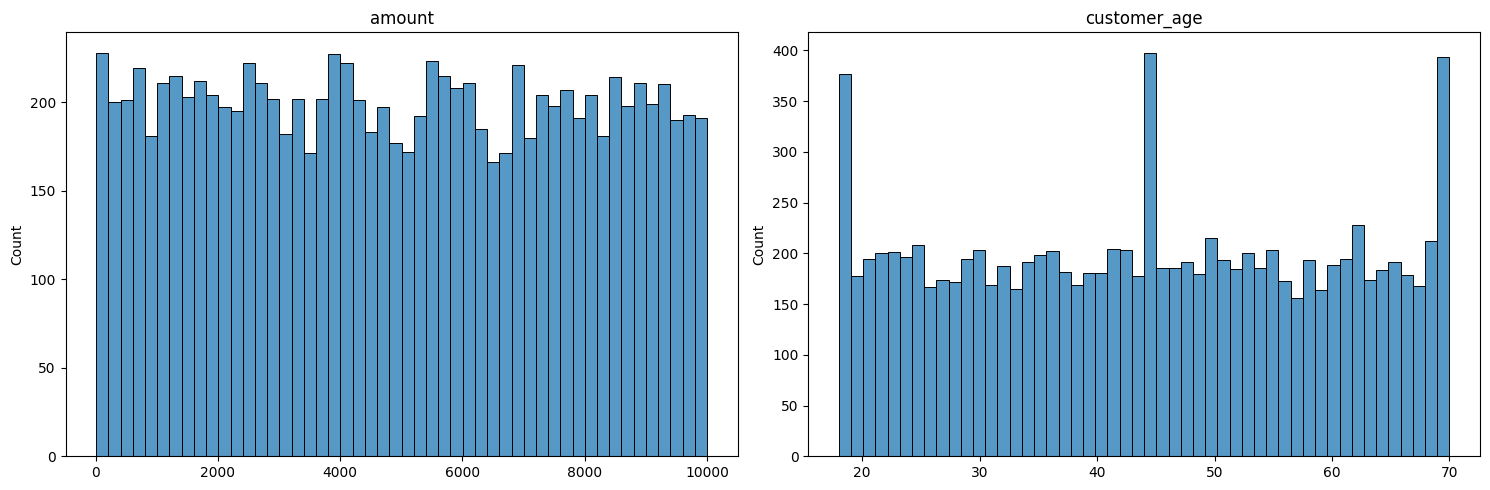

In [14]:
f.plot_numericas(df_num)

Después de haber hecho algunos cambios en mis tipos de columnas, solo me quedo con dos variables categóricas ( amount, customer_age).
- En cuanto al monto, no hay ningún pico como tal.
- Customer age tiene tres picos, uno en el mínimo, otro en el máximo y otro en lo que aparenta ser la mediana.

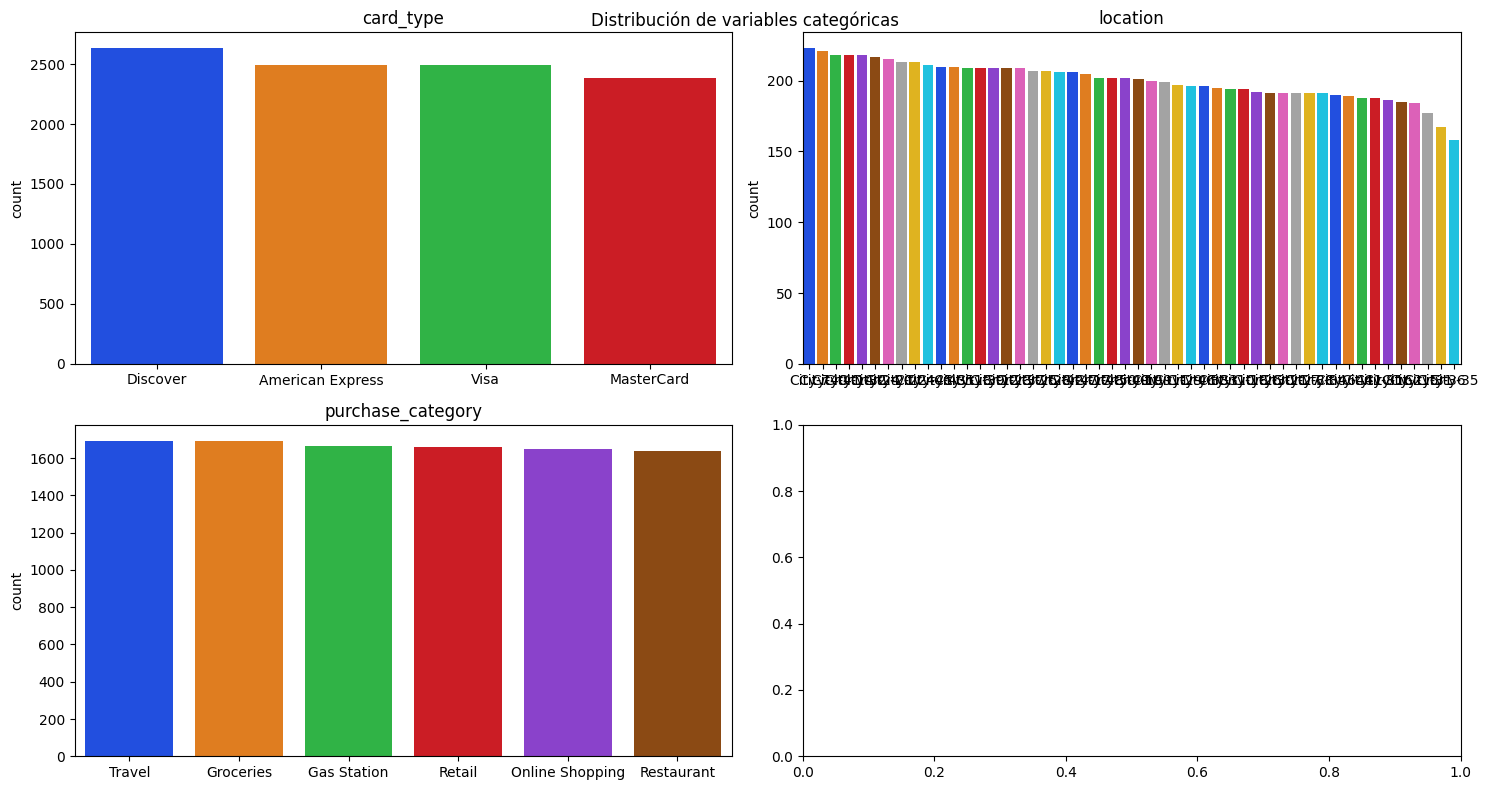

In [15]:
f.plot_categoricas(df_cat)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   transaction_id     10000 non-null  category
 1   customer_id        10000 non-null  category
 2   merchant_id        10000 non-null  category
 3   amount             10000 non-null  float64 
 4   is_fraudulent      10000 non-null  category
 5   card_type          10000 non-null  object  
 6   location           10000 non-null  object  
 7   purchase_category  10000 non-null  object  
 8   customer_age       10000 non-null  int64   
dtypes: category(4), float64(1), int64(1), object(3)
memory usage: 785.6+ KB


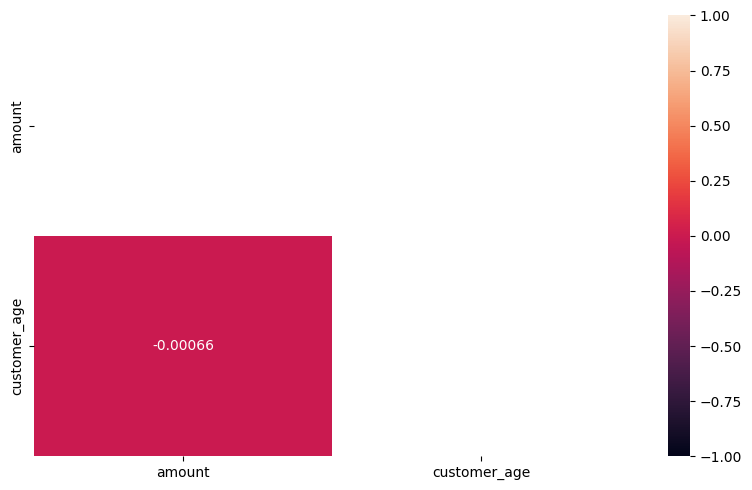

In [16]:
f.matriz_correacion(df)

Entre las variables numéricas no hay correlación.

## Relaciones categóricas con variable respuesta

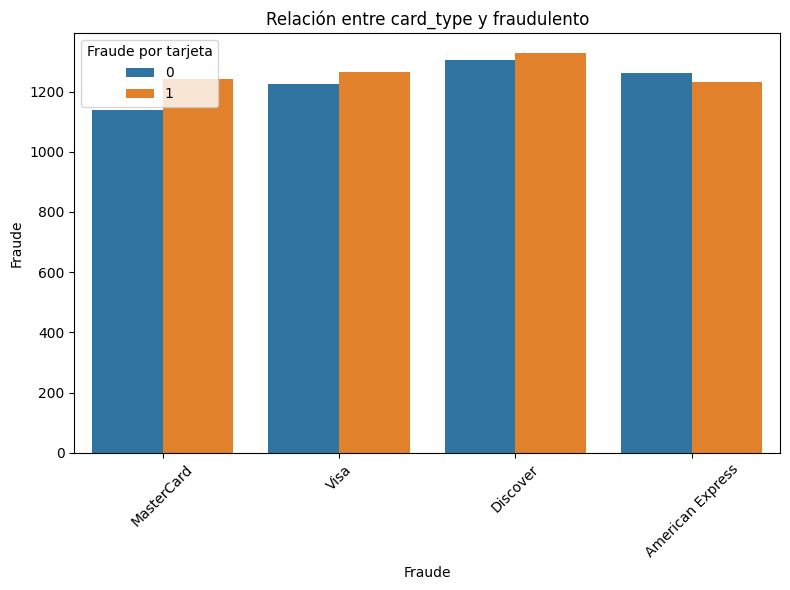

In [18]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='card_type', hue='is_fraudulent')
plt.title('Relación entre card_type y fraudulento')
plt.xlabel('Fraude')
plt.ylabel('Fraude')
plt.legend(title='Fraude por tarjeta')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

No se ven diferencia evidentes entre sí o no por la tarjeta usada. Sin embargo, en todos los casos hay más transacciones fraudulentas que no. Aunque visualmente, la MasterCard es la que tienes menos casos.

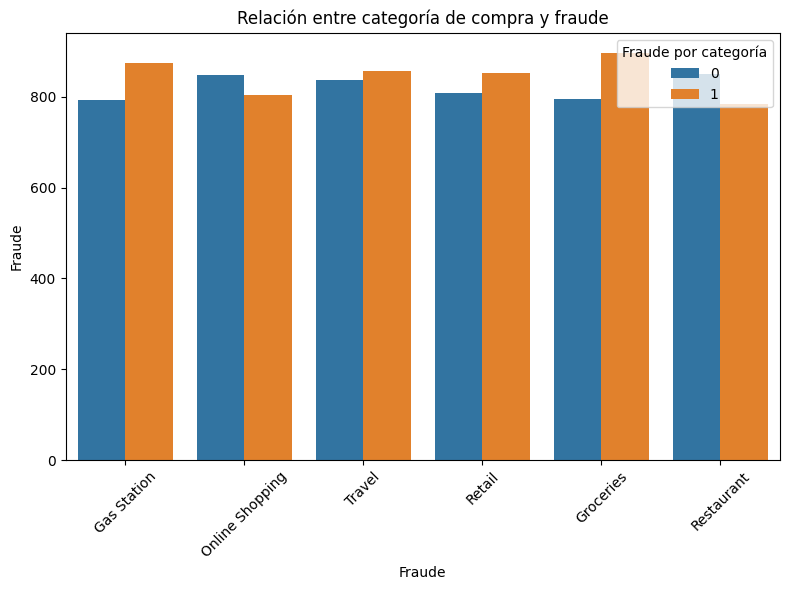

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='purchase_category', hue='is_fraudulent')
plt.title('Relación entre categoría de compra y fraude')
plt.xlabel('Fraude')
plt.ylabel('Fraude')
plt.legend(title='Fraude por categoría')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- Observaciones: 
    -Hay 4 grupos donde el fraude predomina a simple vista:
    (gas station, travel, retail, groceries)
    - En los demás grupos (online shopping y restaurant) hay menos presencia de fraude.

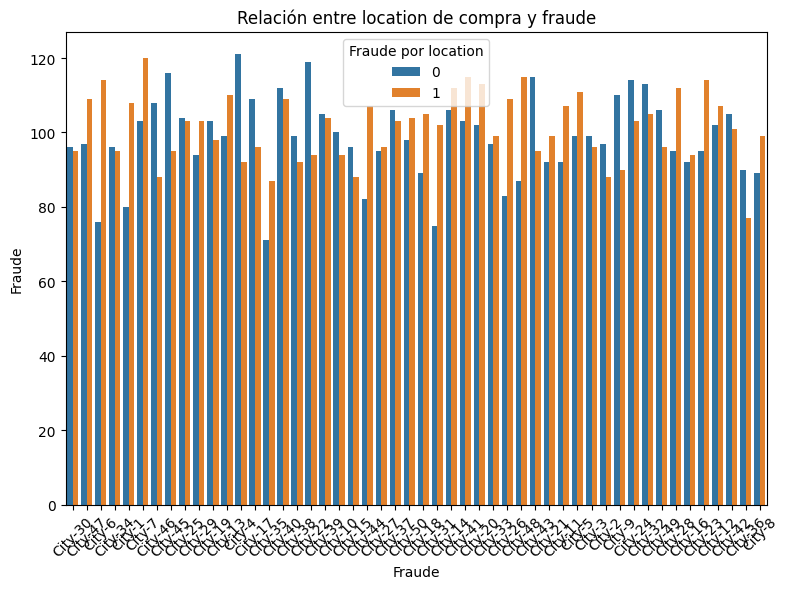

In [21]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='location', hue='is_fraudulent')
plt.title('Relación entre location de compra y fraude')
plt.xlabel('Fraude')
plt.ylabel('Fraude')
plt.legend(title='Fraude por location')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

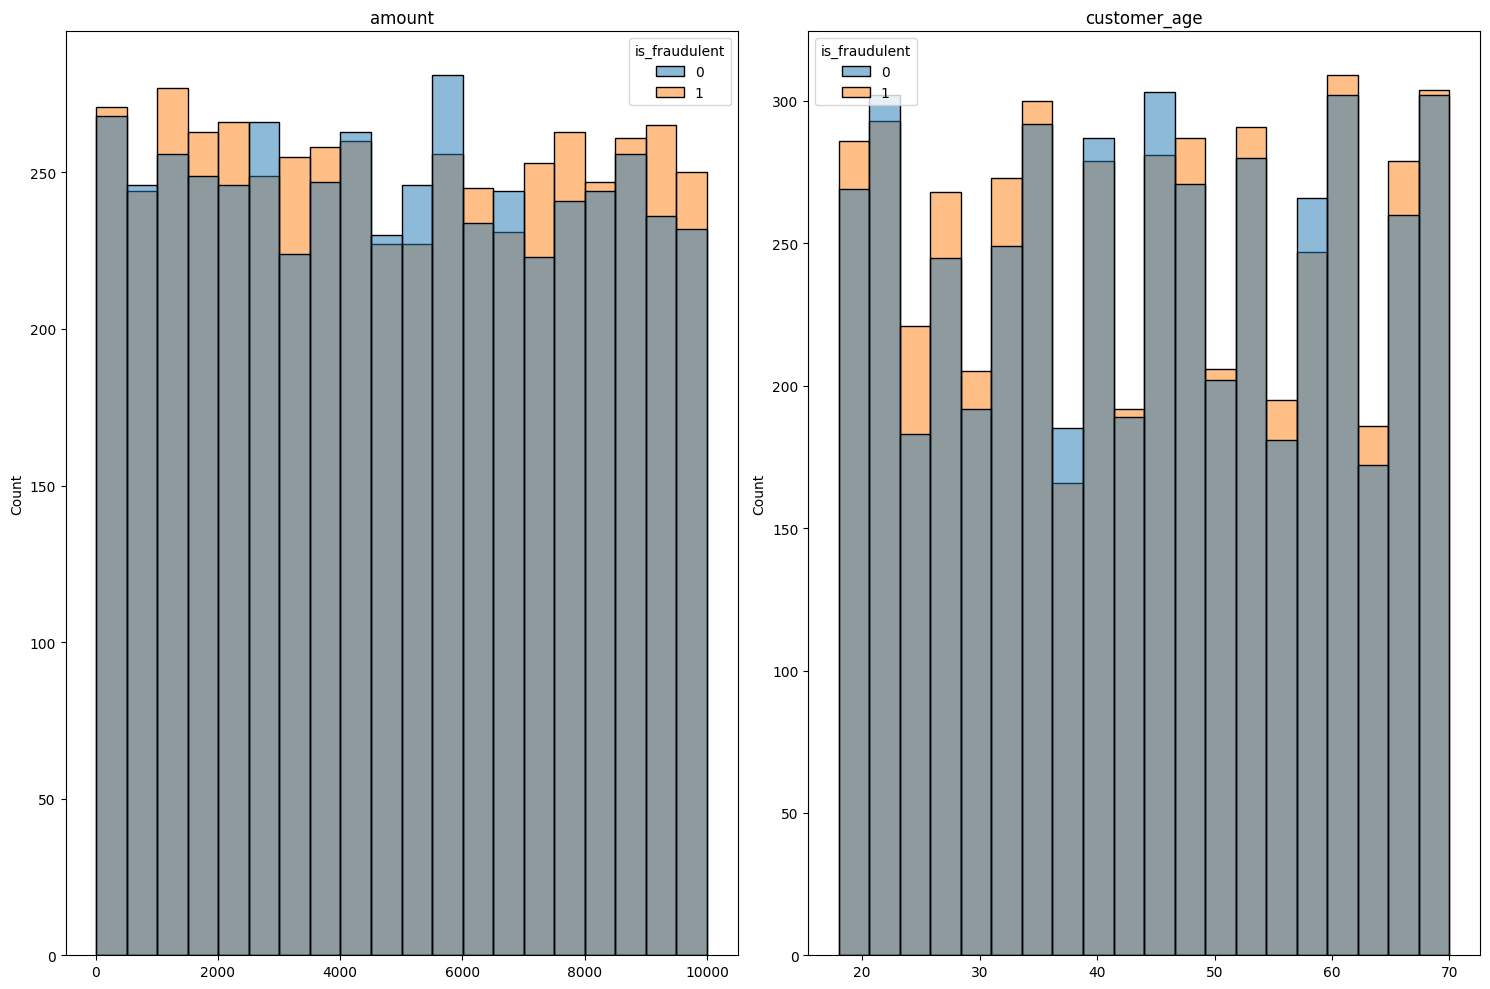

In [23]:
f.relacion_vr_numericas_problema_categorico(df,'is_fraudulent')